<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF2/Q6P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 3

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://www.kaggle.com/srinathsrinivasan1/sunspots-prediction-using-lstm#Plotting-the-time-series-Data
## Caso de estudo: Série temporal de manchas solares [Sunspots](https://www.kaggle.com/robervalt/sunspots) de 1749 a julho de 2018 

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes <br>

### 6.1. Download do dataset diretamente do Kaggle



In [1]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samuelbfg","key":"da367e15e5a2ebae946fdaf52083969c"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 40.8MB/s]


### 6.2. Importações e definições

In [14]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Tempo')
    plt.ylabel('Valor da série')
    plt.title("Série Temporal de Manchas Solares")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


### 6.3. Carregando a base de dados e apresentando sua composição

In [12]:
!unzip sunspots.zip

Archive:  sunspots.zip
  inflating: Sunspots.csv            


In [18]:
import csv
time_step = []
sunspots = []

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
print(series)

[ 96.7 104.3 116.7 ...  34.   21.8  10.4]


### 6.4. Exibindo o comportamento temporal da série não-linear

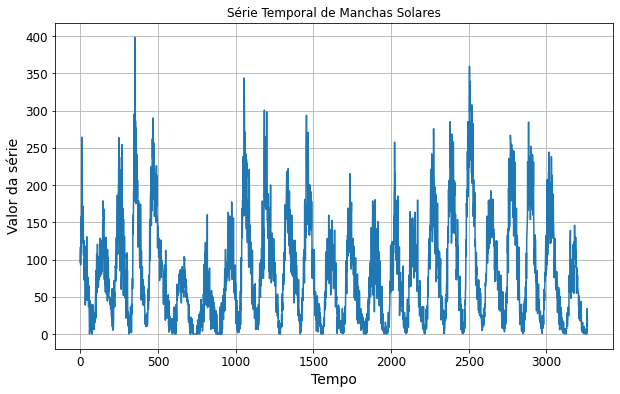

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

### 6.5. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [20]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


    
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
# create train, test data
seq_len = 20 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2596, 20)
y_train.shape =  (2596, 1)
x_valid.shape =  (324, 20)
y_valid.shape =  (324, 1)
x_test.shape =  (324, 20)
y_test.shape =  (324, 1)


### 6.6. Visualização do comportamento da série temporal de teste

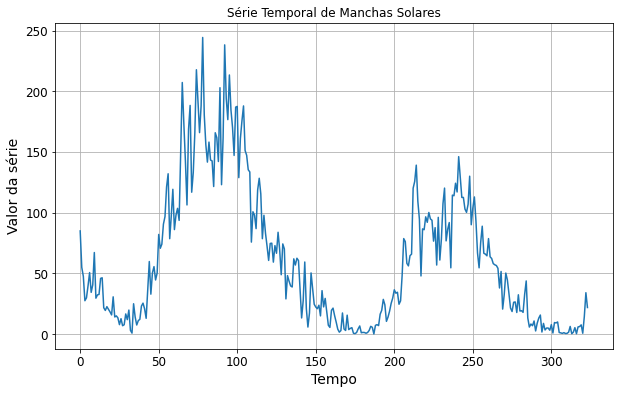

In [25]:
plt.figure(figsize=(10, 6))
plot_series(range(len(y_test)),y_test)

### 6.7. Sintetizando um preditor linear

In [26]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-5.58526591e-02 -1.86141956e-02 -6.84375849e-02  1.21736206e-04
 -4.54187475e-02  1.83688053e-02  1.35554758e-02 -3.08674211e-03
  1.31096342e-02  1.56315426e-02  1.23365809e-02  1.10774324e-01
  1.81866584e-02  2.41492753e-03  7.17480330e-02  4.04360990e-02
  7.63555480e-02  8.94291286e-02  9.84846971e-02  5.38774627e-01
  0.00000000e+00]


#### 6.7.1. Visualização do desempenho do preditor linear

In [27]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
644.0211637971671
EQM final de validação após o término do treinamento - Preditor Linear
731.7064837987845
EQM final de teste após o término do treinamento - Preditor Linear
369.6313155345603


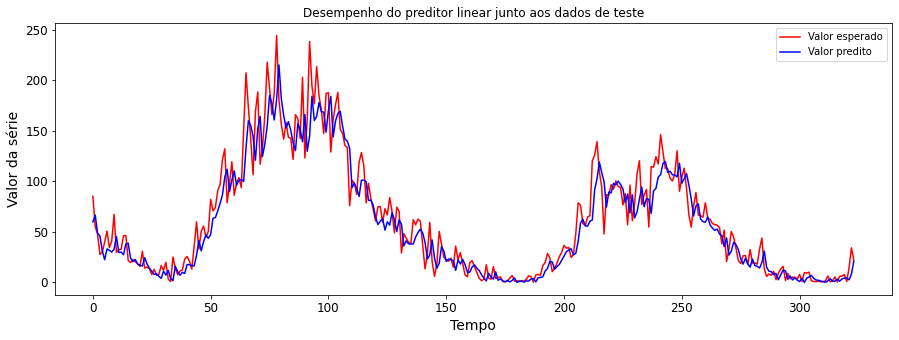

In [30]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear MLP

In [31]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
82/82 [==============================] - 1s 3ms/step - loss: 9385.6406 - val_loss: 14803.9736
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 8490.9180 - val_loss: 13804.6387
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 7869.0547 - val_loss: 12913.9170
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 7317.1426 - val_loss: 12091.7998
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 6819.6040 - val_loss: 11346.1230
Epoch 6/100
82/82 [==============================] - 0s 2ms/step - loss: 6369.3062 - val_loss: 10660.6816
Epoch 7/100
82/82 [==============================] - 0s 2ms/step - loss: 5966.6323 - val_loss: 10038.6758
Epoch 8/100
82/82 [==============================] - 0s 2ms/step - loss: 5596.3159 - val_loss: 9441.5020
Epoch 9/100
82/82 [==============================] - 0s 2ms/step - loss: 5270.3311 - val_loss: 8910.9795
Epoch 10/100
82/82 [============================

In [32]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor MLP

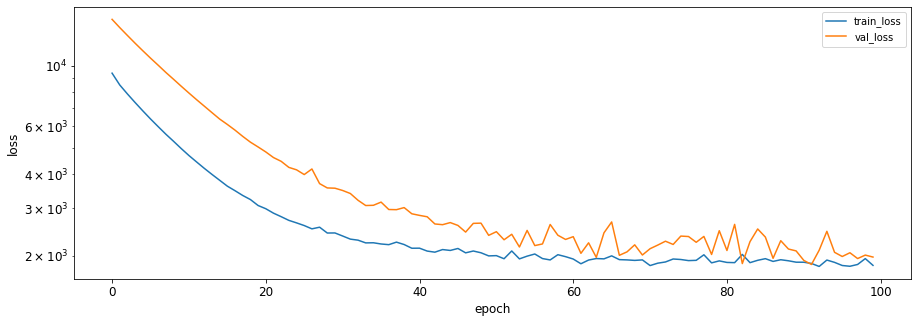

In [33]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [34]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
1795.4599973267707
EQM final de validação após o término do treinamento - Preditor MLP
1857.12844443337
EQM final de teste após o término do treinamento - Preditor MLP
1054.6476881824967


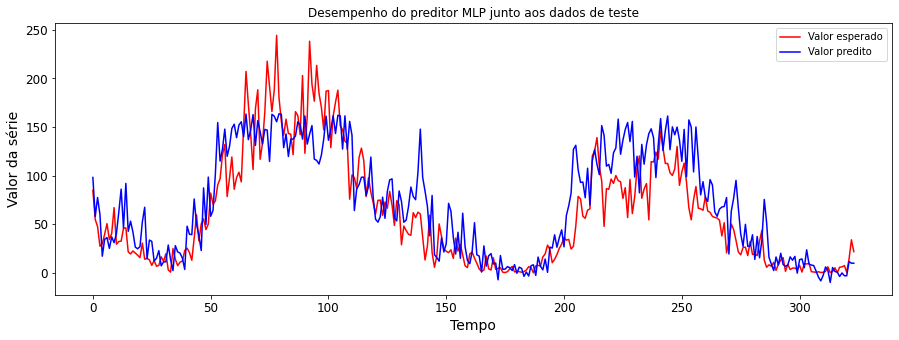

In [52]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear Simple RNN

In [36]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(2596, 20, 1)
(2596, 1)
(324, 20, 1)
(324, 1)
(324, 20, 1)
(324, 1)
Epoch 1/100
82/82 [==============================] - 2s 10ms/step - loss: 10413.2695 - val_loss: 16650.7500
Epoch 2/100
82/82 [==============================] - 1s 7ms/step - loss: 9917.6934 - val_loss: 16205.7959
Epoch 3/100
82/82 [==============================] - 1s 7ms/step - loss: 9644.7021 - val_loss: 15831.2480
Epoch 4/100
82/82 [==============================] - 1s 7ms/step - loss: 9396.3037 - val_loss: 15475.2344
Epoch 5/100
82/82 [==============================] - 1s 7ms/step - loss: 9160.3984 - val_loss: 15136.8955
Epoch 6/100
82/82 [==============================] - 1s 7ms/step - loss: 8934.3350 - val_loss: 14807.6758
Epoch 7/100
82/82 [==============================] - 1s 7ms/step - loss: 8716.9043 - val_loss: 14490.9580
Epoch 8/100
82/82 [==============================] - 1s 7ms/step - loss: 8503.8955 - val_loss: 14181.5234
Epoch 9/100
82/82 [==============================] - 1s 7ms/step - loss: 8301.3408

In [37]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

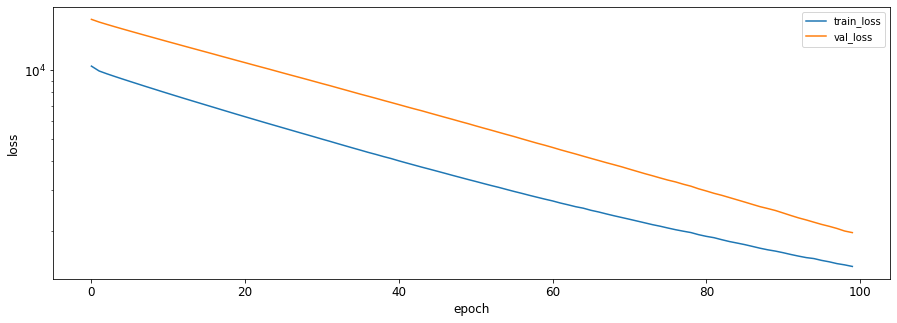

In [38]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [39]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
1390.4862072406352
EQM final de validação após o término do treinamento - Preditor Simple RNN
1959.0561583840345
EQM final de teste após o término do treinamento - Preditor Simple RNN
522.5242605186365


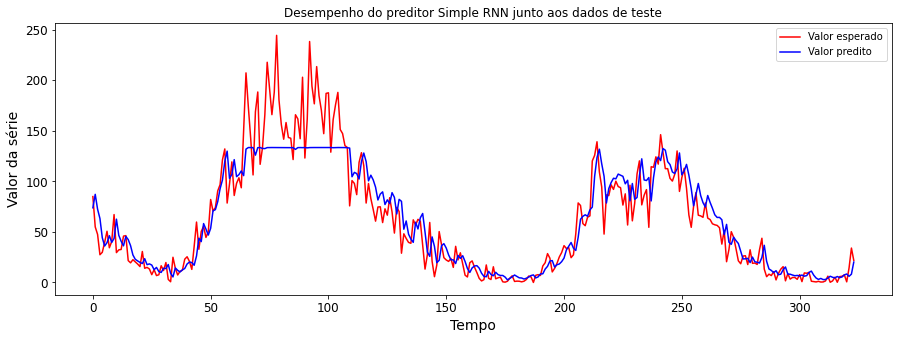

In [53]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear com bloco LSTM GRU

In [41]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(2596, 20, 1)
(2596, 1)
(324, 20, 1)
(324, 1)
(324, 20, 1)
(324, 1)
Epoch 1/100
82/82 [==============================] - 5s 24ms/step - loss: 10448.5117 - val_loss: 16572.1602
Epoch 2/100
82/82 [==============================] - 1s 16ms/step - loss: 9847.2686 - val_loss: 16076.9258
Epoch 3/100
82/82 [==============================] - 1s 16ms/step - loss: 9550.4834 - val_loss: 15681.4922
Epoch 4/100
82/82 [==============================] - 1s 16ms/step - loss: 9291.5166 - val_loss: 15312.5635
Epoch 5/100
82/82 [==============================] - 1s 16ms/step - loss: 9050.7803 - val_loss: 14967.9795
Epoch 6/100
82/82 [==============================] - 1s 16ms/step - loss: 8822.8975 - val_loss: 14634.8086
Epoch 7/100
82/82 [==============================] - 1s 16ms/step - loss: 8606.6807 - val_loss: 14315.6621
Epoch 8/100
82/82 [==============================] - 1s 16ms/step - loss: 8400.3643 - val_loss: 14008.7979
Epoch 9/100
82/82 [==============================] - 1s 16ms/step - loss: 8

In [42]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

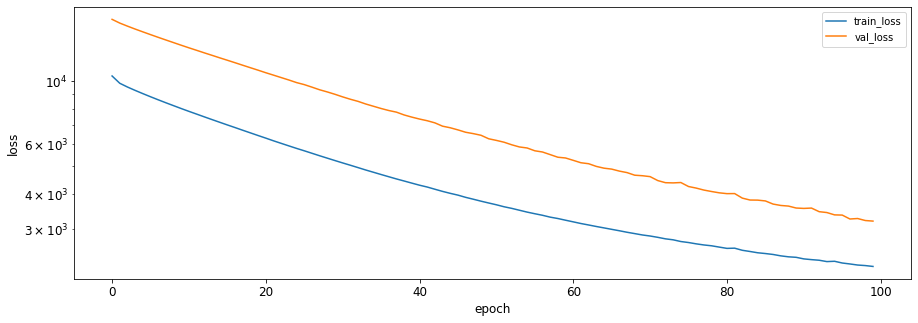

In [43]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [44]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
82/82 [==============================] - 0s 4ms/step - loss: 2193.1155
EQM final de validação após o término do treinamento - Preditor LSTM GRU
11/11 [==============================] - 0s 4ms/step - loss: 3204.1970
EQM final de teste após o término do treinamento - Preditor LSTM GRU
11/11 [==============================] - 0s 4ms/step - loss: 1243.4406


1243.4405517578125

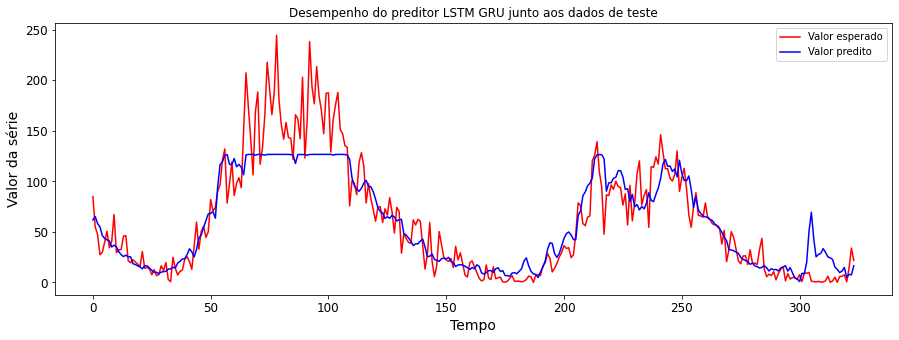

In [54]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.11. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [46]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [47]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [48]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/100
82/82 [==============================] - 14s 8ms/step - loss: 4544.5128 - val_loss: 1924.1678
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 1432.2044 - val_loss: 1455.2264
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 968.2767 - val_loss: 1089.8412
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 879.6991 - val_loss: 949.8097
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 798.5933 - val_loss: 895.7645
Epoch 6/100
82/82 [==============================] - 0s 2ms/step - loss: 774.5802 - val_loss: 866.8887
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 751.5401 - val_loss: 842.6013
Epoch 8/100
82/82 [==============================] - 0s 3ms/step - loss: 776.6927 - val_loss: 872.0876
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 717.1041 - val_loss: 810.7513
Epoch 10/100
82/82 [==============================] - 0s 3ms/step -

#### 6.11.1. Carregando o modelo com o menor MAPE para o preditor CNN

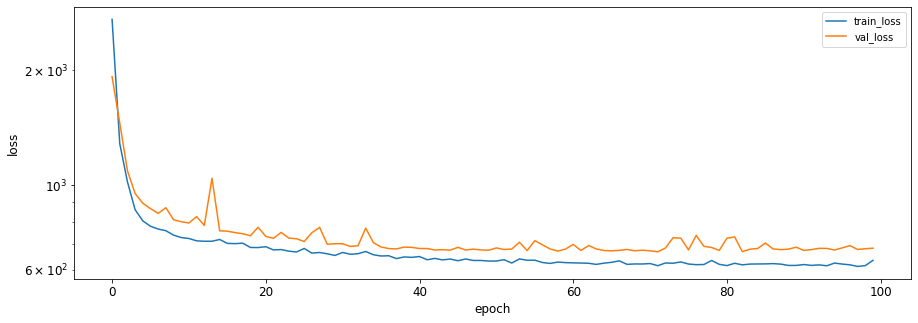

In [49]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.11.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [50]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
611.8898621023252
EQM final de validação após o término do treinamento - Preditor CNN
668.0702566358382
EQM final de teste após o término do treinamento - Preditor CNN
363.6250151845577


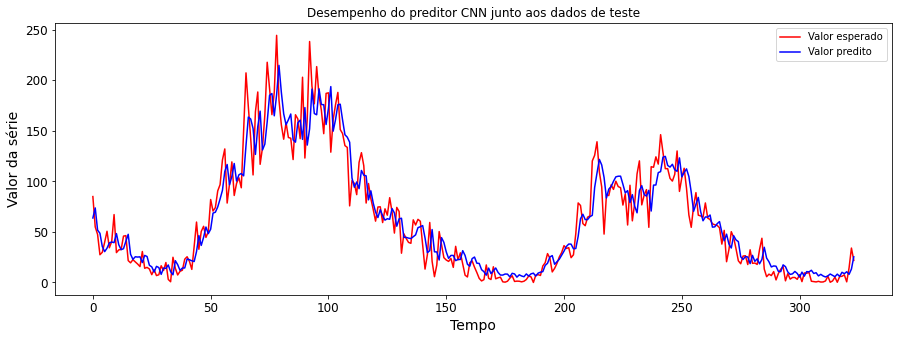

In [55]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

## Resultados


### O objetivo desse notebook é comparar diferentes modelos lineares e não-lineares para predição da famosa série temporal sunspot. O tamanho da sequência (janela) adotado foi de 20 amostras.

#### Para comparação, são construídos 4 modelos não-lineares (MLP, RNN, LSTM-GRU, 1D CNN) e um linear (LR). Os modelos foram construídos exatamente igual as partes 1 e 2 dessa questão, tanto nos hiperparâmetros das redes (taxa de aprendizado, número de camadas/neurônios, épocas, etc.) como na forma de regularização das mesmas (EarlyStopping).

#### Os resultados sugerem que o modelo com o menor erro quadrático médio junto aos dados de teste foi o preditor não-linear convolucional 1D. Curiosamente, o segundo preditor com melhor performance foi o linear.
